### First Steps
1.- Create de Spark context (in local machine)

In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')
print(sc)

<SparkContext master=local[*] appName=pyspark-shell>


2.- Read a input file, creating a RDD. Show the first record

In [2]:
# Reading users file
user_data = sc.textFile("Datasets/ml-100k/u.user") 
print(user_data)
user_data.first()

Datasets/ml-100k/u.user MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0


'1|24|M|technician|85711'

3.- Print some information about users

In [3]:
# Get user data fields (string split separate by |)
user_fields = user_data.map(lambda line: line.split("|"))
print("User record data: " +format(user_fields.first()))
# Get first field of all user records. Then print only the 10st (take(10)).
print(user_fields.map(lambda fields: fields[0]).take(10))
# Count the number of users (records).
num_users = user_fields.map(lambda fields: fields[0]).count()
# Count the number of distinct genders (fields[2])
num_genders = user_fields.map(lambda fields:fields[2]).distinct().count()
# Count the number of diferent ocupations (fields[3])
num_occupations = user_fields.map(lambda fields:fields[3]).distinct().count()
# Count the number of diferent zip codes (fields[4])
num_zipcodes = user_fields.map(lambda fields:fields[4]).distinct().count()
print ("Some Statistics -> Users: %d, genders: %d, occupations: %d, ZIP codes: %d" % 
(num_users, num_genders, num_occupations, num_zipcodes))

User record data: ['1', '24', 'M', 'technician', '85711']
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
Some Statistics -> Users: 943, genders: 2, occupations: 21, ZIP codes: 795


4. We can create a histogram to analyze the distribution of user ages, using matplotlib's hist function:
    - We obtain a array of user ages.
    - We passed in the ages array, together with the number of bins for our histogram (20 in this case), to the hist function. Using the normed=True argument, we also specified that we want the histogram to be normalized so that each bucket represents the percentage of the overall data that falls into that bucket.

[24, 53, 23, 24, 33, 42, 57, 36, 29, 53]


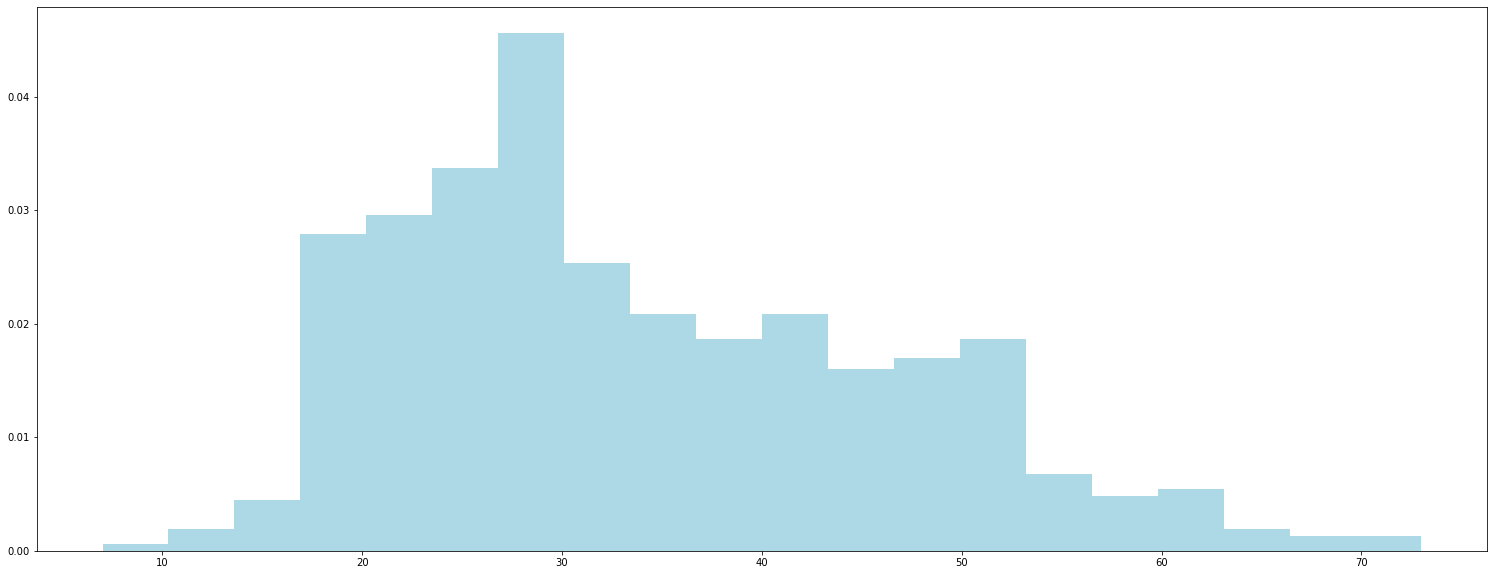

In [4]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Get the list of ages.
ages = user_fields.map(lambda x: int(x[1])).collect()
print(user_fields.map(lambda x: int(x[1])).take(10))
# Create and plot the histogram
plt.hist(ages, bins=20, color='lightblue', density=True)
fig = plt.gcf()
fig.set_size_inches(26, 10)

### HELP Command

You can use the `help` comand to get information about a spark/python function

For example, you can get information about the map function:

In [5]:
help(map)

Help on class map in module builtins:

class map(object)
 |  map(func, *iterables) --> map object
 |  
 |  Make an iterator that computes the function using arguments from
 |  each of the iterables.  Stops when the shortest iterable is exhausted.
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



## Resilient Distributed Datasets (RDDs)

RDDs represent a collection of items distributed across many compute nodes that can be manipulated in parallel.
* Spark’s basic unit of data
* Immutable, fault tolerant collection of records that can be distributed and  operated on in parallel across a cluster
* Fault tolerance:
    If data in memory is lost it will be recreated from lineage
* Caching, persistence (memory, spilling, disk) and check-pointing
* Many database or file type can be supported

An RDD is physically distributed across the cluster, but manipulated as one logical entity:
* Each RDD is split into multiple partitions, which may be computed on different nodes of the cluster.
* Spark will “distribute” any required processing to all partitions where the RDD exists and perform necessary redistributions and aggregations as well.

There are two ways to create RDDs: 

* Parallelizing an existing collection in your driver program.
* Referencing a dataset in an external storage system, such as a shared filesystem, HDFS, HBase, or any data source offering a Hadoop InputFormat.

#### Parallelizing an existing collection

Parallelized collections are created by calling SparkContext’s parallelize method on an existing iterable or collection in your driver program.

In [6]:
import numpy as np
numbers = sc.parallelize(["uno", "dos", "tres"])
print(numbers)
print("Numbers: " +format(numbers.collect()))
# Parallelize an array with 1000 elements
array = sc.parallelize(np.array(range(1000)))
print("Array:" +format(array.take(10)) + " .. " + format(array.take(1000)[-10:]))

ParallelCollectionRDD[23] at readRDDFromFile at PythonRDD.scala:274
Numbers: ['uno', 'dos', 'tres']
Array:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] .. [990, 991, 992, 993, 994, 995, 996, 997, 998, 999]


Once created, the distributed dataset can be operated on in parallel, depending on the number of partitions defined.
* Spark will run one task for each partition of the cluster.

In [7]:
print(array.reduce(lambda a,b: a+b))

499500


Normally, Spark tries to set the number of partitions automatically based on your cluster

In [8]:
print("Numbers partitions " +format(array.getNumPartitions()))
print("Array partitions " +format(array.getNumPartitions()))

Numbers partitions 2
Array partitions 2


However, you can also set it manually by passing it as a second parameter to parallelize (e.g. sc.parallelize(data, 10)).
* Typically you want 2-4 partitions for each CPU in your cluster

In [9]:
# You can also set the number of partitions manually by passing it as a second parameter to parallelize
data = range(100)
distData = sc.parallelize(data,10)
print("Num Partitions: " + format(distData.getNumPartitions()))
print(distData.glom().collect())
text_file = sc.textFile("Datasets/Books/*.txt")
print("Num Partitions (./Datasets/Books/*.txt): " + format(text_file.getNumPartitions()))

Num Partitions: 10
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59], [60, 61, 62, 63, 64, 65, 66, 67, 68, 69], [70, 71, 72, 73, 74, 75, 76, 77, 78, 79], [80, 81, 82, 83, 84, 85, 86, 87, 88, 89], [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]
Num Partitions (./Datasets/Books/*.txt): 4


#### Managing Spark Partitions with Coalesce and Repartition

* **coalesce(numPartitions): **	Decrease the number of partitions in the RDD to numPartitions. 
    Useful for running operations more efficiently after filtering down a large dataset. 

* ** repartition(numPartitions):**	Reshuffle the data in the RDD randomly to create either more or fewer partitions and balance it across them. 
    This always shuffles all data over the network. 
    
* ** partitionBy(numPartitions, partitionFunc): **  Partition by key, using a partitioning function (by default, a hash of the key)
    * For key / value RDDs
    * The same key to the same partition

In [10]:
print("Original Num Partitions: " + format(distData.getNumPartitions()))
print(distData.glom().collect())

distData2 = distData.repartition(20)
print("Increased Num Partitions: " + format(distData2.getNumPartitions()))
print(distData2.glom().collect())

distData3 = distData2.coalesce(5)
print("Decreased Num Partitions: " + format(distData3.getNumPartitions()))
print(distData3.glom().collect())

pairs = sc.parallelize([("a",2), ("b",5), ("a",8), ("b", 6), ("b",1)],5)
print("Original Pairs Num Partitions: " + format(pairs.getNumPartitions()) + " -> " +format(pairs.glom().collect()))
sets = pairs.partitionBy(2)
print("Changed Pairs Num Partitions: " + format(sets.getNumPartitions()) + " -> " +format(sets.glom().collect()))

Original Num Partitions: 10
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59], [60, 61, 62, 63, 64, 65, 66, 67, 68, 69], [70, 71, 72, 73, 74, 75, 76, 77, 78, 79], [80, 81, 82, 83, 84, 85, 86, 87, 88, 89], [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]
Increased Num Partitions: 20
[[], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [], [], [], [], [], [], [], [60, 61, 62, 63, 64, 65, 66, 67, 68, 69], [90, 91, 92, 93, 94, 95, 96, 97, 98, 99], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [80, 81, 82, 83, 84, 85, 86, 87, 88, 89], [], [], [], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]]
Decreased Num Partitions: 5
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 80, 81, 82, 83, 84,

Keep in mind that repartitioning your data is a fairly expensive operation. the coalesce() Spark method is an optimized version of repartition() that allows avoiding data movement, but only if you are decreasing the number of RDD partitions. Coalece() avoids a full shuffle. If it's known that the number is decreasing then the executor can safely keep data on the minimum number of partitions, only moving the data off the extra nodes, onto the nodes that we kept.

For example, with the following partitions: 
* Node 1 = 1,2,3 
* Node 2 = 4,5,6 
* Node 3 = 7,8,9 
* Node 4 = 10,11,12

Then coalesce down to 2 partitions: 
* Node 1 = 1,2,3 + (10,11,12) 
* Node 3 = 7,8,9 + (4,5,6)

Notice that Node 1 and Node 3 did not require its original data to move.

In [11]:
# Test performance of repartition vs coalesce
print("Num Partitions (./Datasets/Books/*.txt): " + format(text_file.getNumPartitions()))
from time import time
t0 = time()
text_file2 = text_file.repartition(2)
tt = time() - t0
print("Num Partitions (./Datasets/Books/*.txt): " + format(text_file2.getNumPartitions()) + " completed in {} seconds".format(round(tt,3)))

t0 = time()
text_file3 = text_file.coalesce(2)
tt = time() - t0
print("Num Partitions (./Datasets/Books/*.txt): " + format(text_file3.getNumPartitions()) + " completed in {} seconds".format(round(tt,3)))

Num Partitions (./Datasets/Books/*.txt): 4
Num Partitions (./Datasets/Books/*.txt): 2 completed in 0.045 seconds
Num Partitions (./Datasets/Books/*.txt): 2 completed in 0.003 seconds


##### Referencing an external dataset

* **Reading and Writting text files**

In [12]:
import os, shutil
if os.path.exists("/home/jovyan/work/Results/WriteFiles"): 
    shutil.rmtree("/home/jovyan/work/Results/WriteFiles")
if os.path.exists("Results/Text_File"): 
    shutil.rmtree("Results/Text_File")
    
# Reads all zip files in the directory and creates a partitioned list of lines
lines = sc.textFile("Datasets/Books/Zipped/*.gz")
words = lines.flatMap(lambda x: x.split(" "))
# Save the RDD words to several output files (one file per partition)
words.saveAsTextFile("file:////home/jovyan/work/Results/WriteFiles")
        
# Reads files and returns a key pair / key value -> filename, value-> complete file
rdd=sc.wholeTextFiles("Datasets/Books/Zipped/")

# Get a key list / key value-> file name, value-> number of words
flist = rdd.mapValues(lambda x: len(x.split()))
for book in flist.collect():
    print("The {0:14s} file has {1:6d} words"
          .format(book[0].split("/")[-1], book[1]))
    
# Write File sizes.
flist.saveAsTextFile("Results/Text_File")

The pg1661.txt.gz  file has 107533 words
The pg2000.txt.gz  file has 384260 words
The pg345.txt.gz   file has 164424 words
The pg84.txt.gz    file has  77986 words


* ** Reading and writing JSON files **

In [13]:
import os, shutil
if os.path.exists("Results/Tweets_ES.json"): 
    shutil.rmtree("Results/Tweets_ES.json")

input = sc.textFile("Datasets/Tweets/tweets2.json")
import json
data = input.map(lambda x: json.loads(x))
print("Twiter from " + format(data.first()['user']['name']) + " ->" +format(data.first()['text']))

# Filter Spanish Tweets
short_data = data.filter(lambda t: "es" in t["lang"])\
                 .map(lambda t: {"id":t["id"], "name":t["user"]["name"], "text":t["text"], "lang":t["lang"]})
print(short_data.first())
# Write Spanish Tweets in a text/json file.
short_data.saveAsTextFile("Results/Tweets_ES.json")

Twiter from AmeriGirl ->RT @NolteNC: Morning Joe gives huge credit to Hillary for confronting a critic but laughs hysterically when Cruz "shows up" to do same.
{'id': 727497507379503108, 'name': 'Mica me sigue 13/8:)', 'text': 'RT @ArmyViciconte_: Se tiene que hacer YAAAAA #Con27EstasParaElBailandoMica', 'lang': 'es'}


* ** Read and Writting Sequence files **

    Key/Value files used in Hadoop.
    * Its elements implement the Writable interface

In [14]:
import os, shutil
if os.path.exists("Results/Sequence_files"): 
    shutil.rmtree("Results/Sequence_files")


data = sc.parallelize([("a",2), ("b",5), ("a",8)])
# Save the RDD as sequence file.
data.saveAsSequenceFile("Results/Sequence_files")
# Read sequence file
seq = sc.sequenceFile("Results/Sequence_files", 
                      "org.apache.hadoop.io.Text", 
                      "org.apache.hadoop.io.IntWritable")
print(seq.first())

('a', 2)


* ** Hadoop Input/Output Formats **

    Spark can interact with any file format supported by Hadoop
    * Supports "old" and "new" APIs
    * It allows access to other types of storage (not file), e.g. HBase or MongoDB, via `saveAsHadoopDataSet` and/or `saveAsNewAPIHadoopDataSet`

In [15]:
import os, shutil
if os.path.exists("Results/Hadoop_formats"): 
    shutil.rmtree("Results/Hadoop_formats")

# Save the RDD as a Hadoop (TextOutputFormat)
data.saveAsNewAPIHadoopFile("Results/Hadoop_formats", 
                            "org.apache.hadoop.mapreduce.lib.output.TextOutputFormat",
                            "org.apache.hadoop.io.Text",
                            "org.apache.hadoop.io.IntWritable")

# Read it as a key-value file Hadoop (KeyValueTextInputFormat)
rdd = sc.newAPIHadoopFile("Results/Hadoop_formats", 
                          "org.apache.hadoop.mapreduce.lib.input.KeyValueTextInputFormat",
                          "org.apache.hadoop.io.Text",
                          "org.apache.hadoop.io.IntWritable")
print(rdd.collect())

[('a', '2'), ('b', '5'), ('a', '8')]


* ** Object files **

    Binary files that store any type of RDDs (not just key / value)
    * In Python, pickle is used (`saveAsPickleFile()` and `pickleFile()` methods)
    * Only useful to communicate Spark jobs with each other.

### RDD Caching and Persistence

Problem with using RDD multiple times:
* Spark rebuilds the RDD and its dependencies every time an action is executed
* Very expensive (especially in iterative problems)

Solution
* Keep the RDD in memory and / or disk
* Methods cache () or persist ()

Caching or persistence are optimisation techniques for (iterative and interactive) Spark computations. They help saving interim partial results so they can be reused in subsequent stages. These interim results as RDDs are thus kept in memory (default) or more solid storages like disk and/or replicated.

RDDs can be cached using cache operation. They can also be persisted using persist operation.

The difference between cache and persist operations is purely syntactic. cache is a synonym of persist or persist(MEMORY_ONLY), i.e. cache is merely persist with the default storage level MEMORY_ONLY.

Sparks supports the following [levels of persistence][4], defined in pyspark.StorageLevel:
![Spark persintence levels](assets/spark_persintence_levels.png)

and the main characteristiques for each level are:

![Spark persintence levels features](assets/Persitence_levels_features.png)


#### Levels of persistence
* In Python, the default level is MEMORY_ONLY_SER
    * By default, Python serializes the data as pickled objects
    * You can specify another serialization when creating the SparkContext
        ```python
        Sc = SparkContext (master = "local", appName = "My app", serializer = pyspark.MarshalSerializer ())
        ```

#### Troubleshooting
* If a node with stored data fails, the RDD recovers
    * By adding _2 to the persistence level, 2 copies of the RDD

#### Managing the cache
* LRU algorithm to manage the cache
    * For memory-only levels, old RDDs are deleted and recalculated
    * For memory and disk levels, partitions that do not fit are written to disk


[4]: http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.StorageLevel

In [16]:
#from test_helper import Test
#from __future__ import print_function

rdd = sc.parallelize(range(1000), 10)
print("1. rdd is cached: " +format(rdd.is_cached))

rdd.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2) ## MEMORY_AND_DISK_SER_2 deprecated use MEMORY_AND_DISK_2 instead
print("2. rdd is cached: " +format(rdd.is_cached))

rdd2 = rdd.map(lambda x: x*x)
print("3. rdd2 is cached: " +format(rdd2.is_cached))


rdd2.cache() # Default level
print("4. rdd2 is cached: " +format(rdd2.is_cached))

print("Persitence level for rdd: {0} ".format(rdd.getStorageLevel()))
print("Persitence level for rdd2: {0}".format(rdd2.getStorageLevel()))

rdd.unpersist() # keep out rdd from cache
print("5. rdd is cached: " +format(rdd.is_cached))

1. rdd is cached: False
2. rdd is cached: True
3. rdd2 is cached: False
4. rdd2 is cached: True
Persitence level for rdd: Disk Memory Serialized 2x Replicated 
Persitence level for rdd2: Memory Serialized 1x Replicated
5. rdd is cached: False


#### RDD Fault Tolerance (RDD log lineage)
Spark operates on data in fault-tolerant file systems like HDFS or S3. So all the RDDs generated from fault tolerant data is fault tolerant. 
But this does not set true for streaming/live data (data over the network). So the key need of fault tolerance in Spark is for this kind of data. 

The basic fault-tolerant semantic of Spark are:
* Since Apache Spark RDD is an immutable dataset, each Spark RDD remembers the lineage of the deterministic operation that was used on fault-tolerant input dataset to create it.
* If due to a worker node failure any partition of an RDD is lost, then that partition can be re-computed from the original fault-tolerant dataset using the lineage of operations.
* Assuming that all of the RDD transformations are deterministic, the data in the final transformed RDD will always be the same irrespective of failures in the Spark cluster.

Each RDD maintains a pointer to one or more parent along with the metadata about what type of relationship it has with the parent. 
* For example, when we call val b = a.map() on a RDD, the RDD b just keeps a reference (and never copies) to its parent a, that's a **lineage**.

When the driver submits the job, the RDD graph is serialized to the worker nodes so that each of the worker nodes apply the series of transformations (like, map filter and etc..) on different partitions. Also, this RDD lineage will be used to recompute the data if some failure occurs.

To display the lineage of an RDD, Spark provides a debug method toDebugString() method.

Consider the wordcount example:

In [17]:
text_file = sc.textFile("Datasets/Books/*.txt")
counts = text_file.flatMap(lambda line: line.split(" "))\
                    .map(lambda word: (word, 1))\
                    .reduceByKey(lambda a, b: a + b)
print("Number of Words: " +format(counts.count()))

Number of Words: 71478


Executing toDebugString() on splitedLines RDD, will output the following,

In [18]:
print(counts.toDebugString())

b'(4) PythonRDD[100] at RDD at PythonRDD.scala:53 []\n |  MapPartitionsRDD[98] at mapPartitions at PythonRDD.scala:145 []\n |  ShuffledRDD[97] at partitionBy at NativeMethodAccessorImpl.java:0 []\n +-(4) PairwiseRDD[96] at reduceByKey at <ipython-input-17-369a6da7456a>:2 []\n    |  PythonRDD[95] at reduceByKey at <ipython-input-17-369a6da7456a>:2 []\n    |  Datasets/Books/*.txt MapPartitionsRDD[94] at textFile at NativeMethodAccessorImpl.java:0 []\n    |  Datasets/Books/*.txt HadoopRDD[93] at textFile at NativeMethodAccessorImpl.java:0 []'


The two first lines (from bottom) shows the input RDD. We created this RDD by calling sc.textFile(). 
See below more diagrammatic view of the DAG graph created from a [similar RDD] [3].
![DAG graph](assets/Lb3pQ.png)

Once the DAG is build, Spark scheduler creates a physical execution plan. As mentioned above, the DAG scheduler splits the graph into multiple stages, the stages are created based on the transformations. The narrow transformations will be grouped (pipe-lined) together into a single stage. So for our example, Spark will create two stage execution as follows:
![Stage Execution](assets/K4gJU.png)

The DAG scheduler then submit the stages into the task scheduler. The number of tasks submitted depends on the number of partitions present in the textFile. Fox example consider we have 4 partitions in this example, then there will be 4 set of tasks created and submitted in parallel provided if there are enough slaves/cores. Below diagram illustrates this in bit more detail:
![Tasks Execution](assets/GoYQB.png)

[3]: https://stackoverflow.com/questions/30691385/internal-work-of-spark/30691654#30691654

You can also set the number of partitions manually by passing it as a second parameter to parallelize

In [19]:
# You can also set the number of partitions manually by passing it as a second parameter to parallelize
data = range(100)
distData = sc.parallelize(data,10)
print("Num Partitions: " + format(distData.getNumPartitions()))
text_file = sc.textFile("Datasets/Books/*")

print("Num Partitions (./Datasets/Books/*): " + format(text_file.getNumPartitions()))

Num Partitions: 10
Num Partitions (./Datasets/Books/*): 8
